In [4]:
from multiprocessing import Pool
import os
import time
import pickle
import json
from tqdm import tqdm
import csv
import numpy as np
from utils import load_instances, load_labels, load_annotator_labels
from collections import defaultdict
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import f1_score, confusion_matrix
import seaborn
import matplotlib.pyplot as plt

Since running the prompts through chatgpt are ran through multiprocessing, this `ipynb` will only run metrics on saved prompt files.

In [5]:
response_files = [('gpt4', 'data/gpt4_answers_qiq.pkl'),
('gpt4_no_date', 'data/gpt4_answers_no_date.pkl'), ('gpt4_date', 'data/gpt4_answers_with_date.pkl')]

In [6]:
for model_name, file in response_files:
    with open(file, 'rb') as fp:
            chatgpt_answers = pickle.load(fp)
        
    count = 0
    total_count = 0
    for para_lst in chatgpt_answers:
        for response in para_lst:
            if response["response"] != "1" and response["response"] != "0":
                print("error")
            elif response["response"] == response["label"]:
                count += 1
            
            total_count += 1
    print(f"{model_name} accuracy: {count / total_count}") 

gpt4 accuracy: 0.5984323183599638
gpt4_no_date accuracy: 0.7223394633705156
gpt4_date accuracy: 0.689176967138981


In [7]:
def get_id_to_target_word():
    instances = load_instances()
    
    id_target_dict = {}
    for instance in instances:
        id_target_dict[instance["id"]] = instance["word"]
    
    return id_target_dict

In [8]:

ids_to_word = get_id_to_target_word()
annotator_labels = load_annotator_labels()

for model_name, file in response_files:
    with open(file, 'rb') as fp:
        chatgpt_answers = pickle.load(fp)

    meaning_change = defaultdict(list)

    for para_lst in chatgpt_answers:
        for response in para_lst:
            target_word = ids_to_word[response["id"]]
            if response["response"] != "1" and response["response"] != "0":
                print("error")
            else:
                meaning_change[target_word].append(int(response["response"]))

    mc_dict = {}
    for key in list(meaning_change.keys()):
        mc_dict[key] = np.mean(np.asarray(meaning_change[key]))

    gpt_vec = []
    annotator_vec = []

    for key in annotator_labels.keys():
        gpt_vec.append(float(mc_dict[key]))
        annotator_vec.append(float(annotator_labels[key]))


    pearson, p_value = pearsonr(gpt_vec, annotator_vec)
    print(f"{model_name} pearson corr: {pearson}, p-value: {p_value}")

gpt4 pearson corr: -0.4417201176643979, p-value: 0.00891315314239028
gpt4_no_date pearson corr: -0.6606171837828476, p-value: 2.119047516288605e-05
gpt4_date pearson corr: -0.5635818524639686, p-value: 0.0005190069252002929


gpt4 f1: 0.05531914893617021
gpt4_no_date f1: 0.6266720713417105
gpt4_date f1: 0.6487223168654174


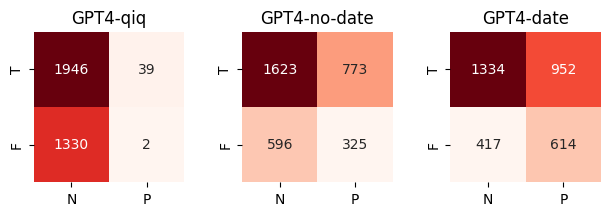

In [9]:
confusion_mats = np.zeros((3, 2, 2))
for i, (model_name, file) in enumerate(response_files):

    with open(file, 'rb') as fp:
        chatgpt_answers = pickle.load(fp)

    response_list = []
    label_list = []

    for para_lst in chatgpt_answers:
        for response in para_lst:
            label_list.append(response["label"])
            response_list.append(response["response"])

    f1 = f1_score(label_list, response_list, average="binary", pos_label="1")
    print(f"{model_name} f1: {f1}")

    cm = confusion_matrix(label_list, response_list)
    cm[0, 1], cm[1, 1] = cm[1, 1], cm[0, 1]
    confusion_mats[i] = cm


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.tight_layout()

ax1.set_title("GPT4-qiq")
ax2.set_title("GPT4-no-date")
ax3.set_title("GPT4-date")


seaborn.heatmap(confusion_mats[0], xticklabels='NP', yticklabels='TF', ax=ax1, annot=True, square=True, cmap='Reds', fmt='g', cbar=False)
seaborn.heatmap(confusion_mats[1], xticklabels='NP', yticklabels='TF', ax=ax2, annot=True, square=True, cmap='Reds', fmt='g', cbar=False)
seaborn.heatmap(confusion_mats[2], xticklabels='NP', yticklabels='TF', ax=ax3, annot=True, square=True, cmap='Reds', fmt='g', cbar=False)
plt.savefig("confusion_mat", bbox_inches='tight')
    